In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to tensor and scales to [0, 1]
])


In [5]:
train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 272kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.05MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.4MB/s]


In [6]:
test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

In [7]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [8]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"\nDataset Information:")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image shape: 28x28 pixels (grayscale)")
print(f"Number of classes: {len(class_names)}")


Dataset Information:
Training samples: 60000
Test samples: 10000
Image shape: 28x28 pixels (grayscale)
Number of classes: 10


In [9]:
class FashionMNISTNet(nn.Module):
    def __init__(self):
        super(FashionMNISTNet, self).__init__()
        # Flatten layer (handled in forward pass)
        # Input: 28x28 = 784 features
        self.fc1 = nn.Linear(784, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        # Flatten the input: batch_size x 1 x 28 x 28 -> batch_size x 784
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [10]:
# Initialize the model
model = FashionMNISTNet().to(device)

In [11]:
# Print model architecture
print("\n" + "="*50)
print("MODEL ARCHITECTURE")
print("="*50)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")


MODEL ARCHITECTURE
FashionMNISTNet(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

Total parameters: 235,146


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [14]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

In [16]:
num_epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print("\n" + "="*50)
print("TRAINING STARTED")
print("="*50)
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc, _, _ = evaluate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    print("-" * 50)

print("\n" + "="*50)
print("TRAINING COMPLETED")
print("="*50)
print(f"Final Train Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")


TRAINING STARTED
Epoch [1/10]
  Train Loss: 0.5211, Train Acc: 81.30%
  Test Loss: 0.4134, Test Acc: 85.07%
--------------------------------------------------
Epoch [2/10]
  Train Loss: 0.3699, Train Acc: 86.37%
  Test Loss: 0.4008, Test Acc: 85.50%
--------------------------------------------------
Epoch [3/10]
  Train Loss: 0.3304, Train Acc: 87.81%
  Test Loss: 0.3596, Test Acc: 87.20%
--------------------------------------------------
Epoch [4/10]
  Train Loss: 0.3066, Train Acc: 88.66%
  Test Loss: 0.3611, Test Acc: 87.08%
--------------------------------------------------
Epoch [5/10]
  Train Loss: 0.2881, Train Acc: 89.24%
  Test Loss: 0.3442, Test Acc: 87.80%
--------------------------------------------------
Epoch [6/10]
  Train Loss: 0.2746, Train Acc: 89.77%
  Test Loss: 0.3353, Test Acc: 88.02%
--------------------------------------------------
Epoch [7/10]
  Train Loss: 0.2602, Train Acc: 90.21%
  Test Loss: 0.3508, Test Acc: 87.11%
---------------------------------------

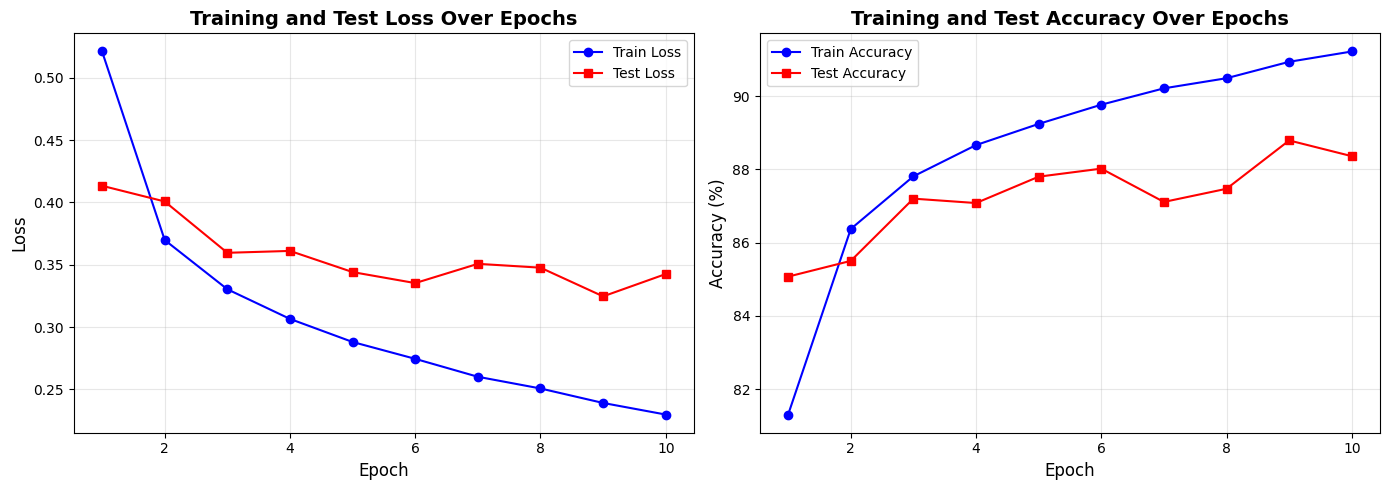

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
ax1.plot(range(1, num_epochs+1), train_losses, 'b-', label='Train Loss', marker='o')
ax1.plot(range(1, num_epochs+1), test_losses, 'r-', label='Test Loss', marker='s')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Test Loss Over Epochs', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(range(1, num_epochs+1), train_accuracies, 'b-', label='Train Accuracy', marker='o')
ax2.plot(range(1, num_epochs+1), test_accuracies, 'r-', label='Test Accuracy', marker='s')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Test Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_progress.png', dpi=300, bbox_inches='tight')
plt.show()

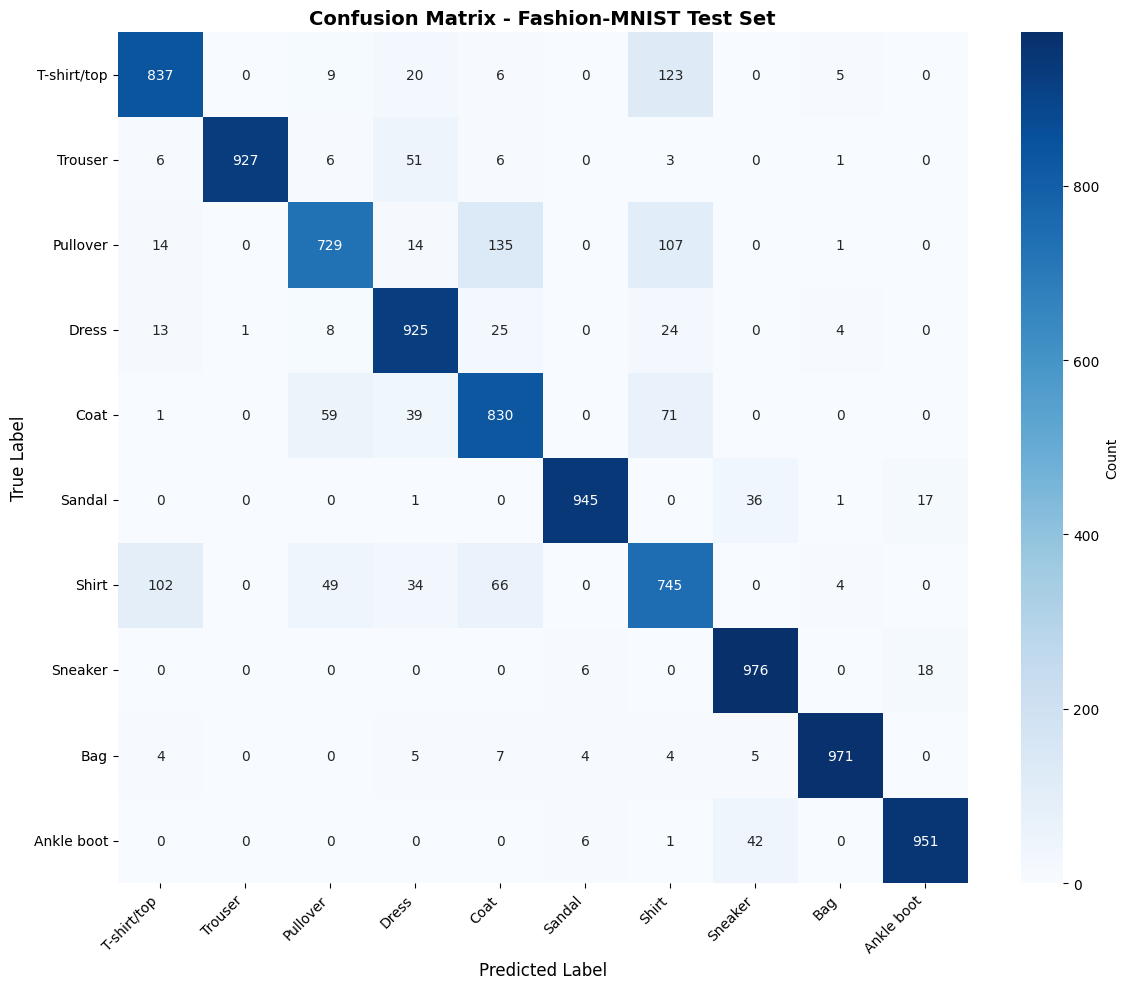

In [18]:
# Get predictions on test set
_, _, test_preds, test_labels = evaluate(model, test_loader, criterion, device)

# Create confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - Fashion-MNIST Test Set', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# Calculate per-class accuracy
print("\n" + "="*50)
print("PER-CLASS ACCURACY")
print("="*50)
class_correct = cm.diagonal()
class_total = cm.sum(axis=1)
for i, class_name in enumerate(class_names):
    accuracy = 100 * class_correct[i] / class_total[i]
    print(f"{class_name:15s}: {accuracy:.2f}% ({class_correct[i]}/{class_total[i]})")


PER-CLASS ACCURACY
T-shirt/top    : 83.70% (837/1000)
Trouser        : 92.70% (927/1000)
Pullover       : 72.90% (729/1000)
Dress          : 92.50% (925/1000)
Coat           : 83.00% (830/1000)
Sandal         : 94.50% (945/1000)
Shirt          : 74.50% (745/1000)
Sneaker        : 97.60% (976/1000)
Bag            : 97.10% (971/1000)
Ankle boot     : 95.10% (951/1000)


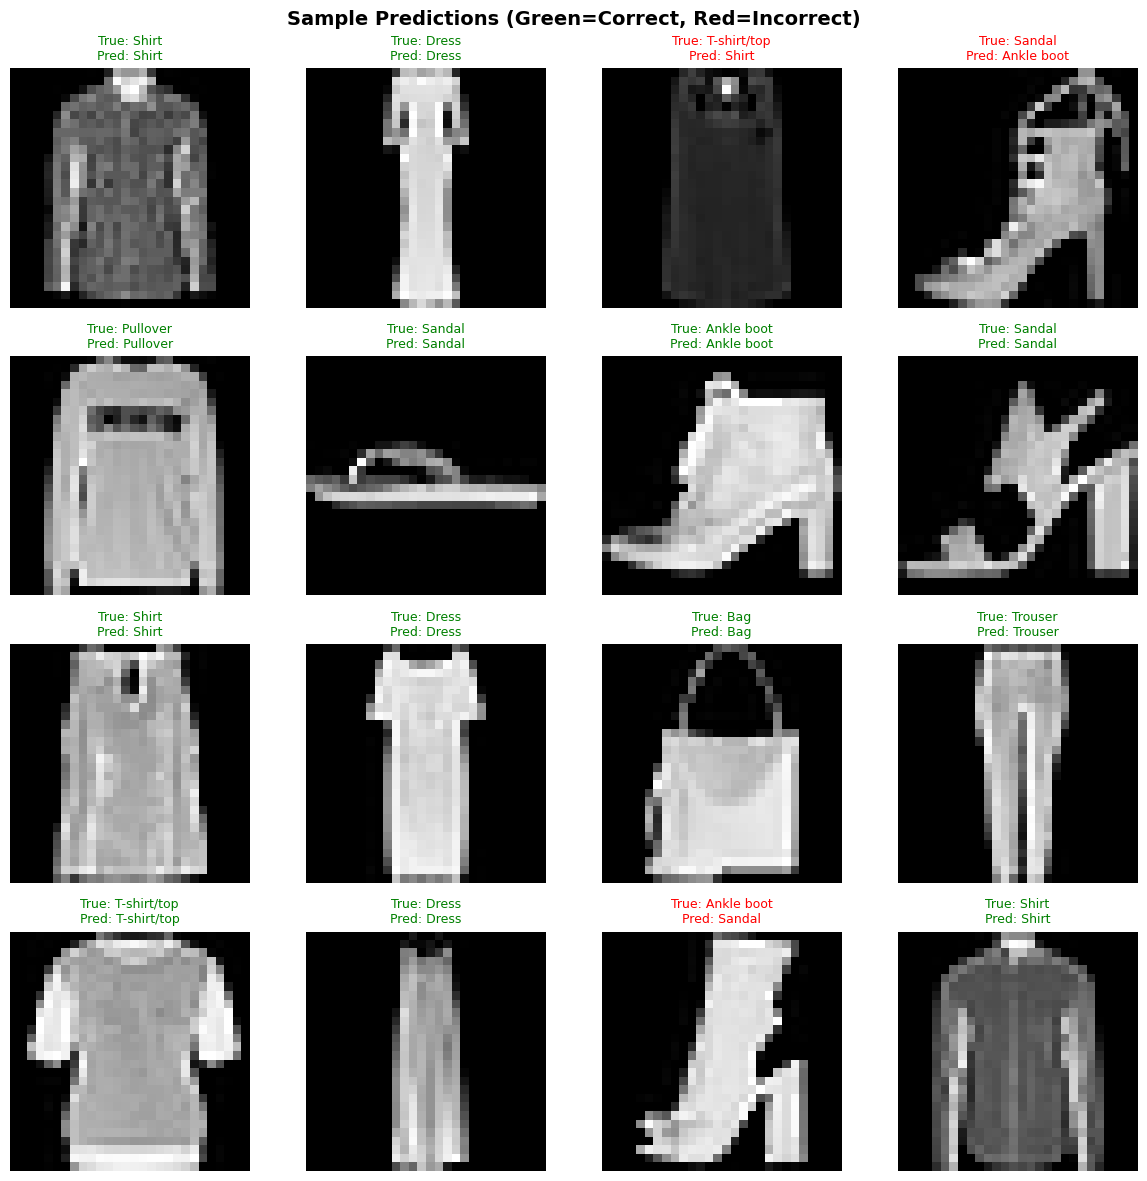

In [20]:
def visualize_predictions(model, dataset, device, num_images=16):
    model.eval()

    # Get random samples
    indices = np.random.choice(len(dataset), num_images, replace=False)

    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.ravel()

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, true_label = dataset[idx]
            image_input = image.unsqueeze(0).to(device)

            output = model(image_input)
            _, predicted = torch.max(output, 1)
            pred_label = predicted.item()

            # Display image
            axes[i].imshow(image.squeeze(), cmap='gray')

            # Set title with color based on correctness
            color = 'green' if pred_label == true_label else 'red'
            axes[i].set_title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}',
                            color=color, fontsize=9)
            axes[i].axis('off')

    plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_predictions(model, test_dataset, device, num_images=16)

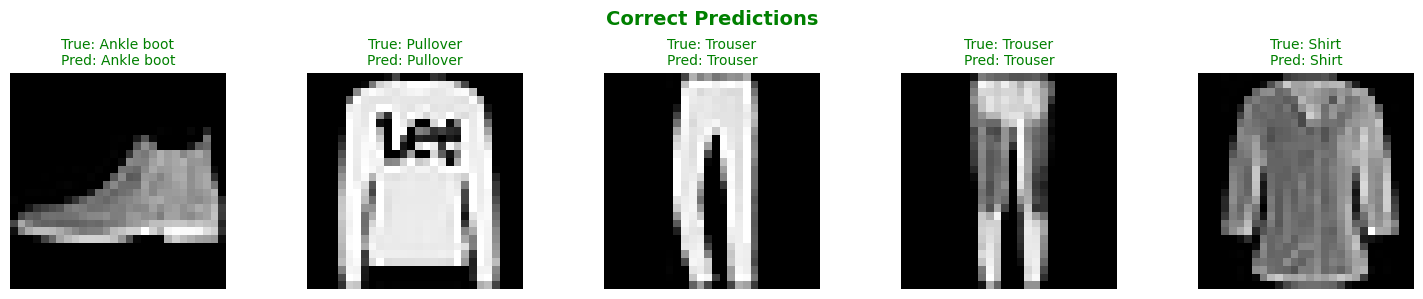

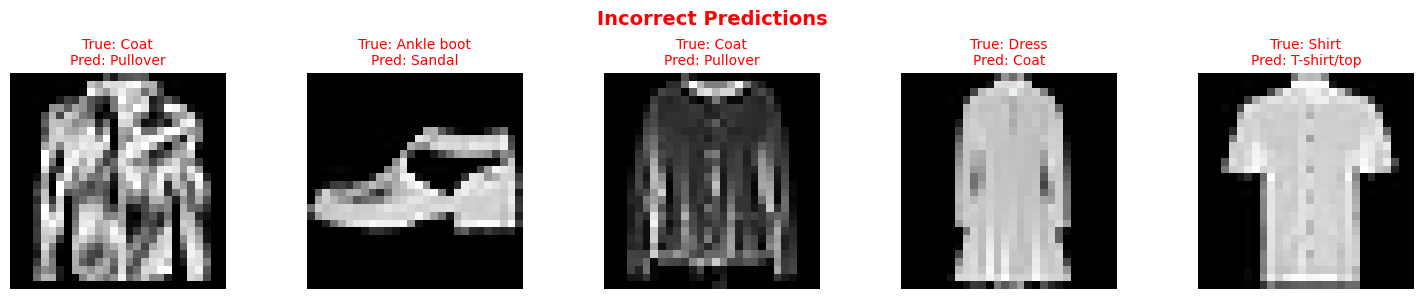

In [23]:
def show_correct_and_incorrect(model, dataset, device, num_each=5):
    model.eval()

    correct_samples = []
    incorrect_samples = []

    with torch.no_grad():
        for idx in range(len(dataset)):
            image, true_label = dataset[idx]
            image_input = image.unsqueeze(0).to(device)

            output = model(image_input)
            _, predicted = torch.max(output, 1)
            pred_label = predicted.item()

            if pred_label == true_label and len(correct_samples) < num_each:
                correct_samples.append((image, true_label, pred_label))
            elif pred_label != true_label and len(incorrect_samples) < num_each:
                incorrect_samples.append((image, true_label, pred_label))

            if len(correct_samples) >= num_each and len(incorrect_samples) >= num_each:
                break

    # Plot correct predictions
    fig, axes = plt.subplots(1, num_each, figsize=(15, 3))
    for i, (image, true_label, pred_label) in enumerate(correct_samples):
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}',
                         color='green', fontsize=10)
        axes[i].axis('off')
    plt.suptitle('Correct Predictions', fontsize=14, fontweight='bold', color='green')
    plt.tight_layout()
    plt.savefig('correct_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Plot incorrect predictions
    fig, axes = plt.subplots(1, num_each, figsize=(15, 3))
    for i, (image, true_label, pred_label) in enumerate(incorrect_samples):
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}',
                         color='red', fontsize=10)
        axes[i].axis('off')
    plt.suptitle('Incorrect Predictions', fontsize=14, fontweight='bold', color='red')
    plt.tight_layout()
    plt.savefig('incorrect_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

show_correct_and_incorrect(model, test_dataset, device, num_each=5)

In [27]:
torch.save(model.state_dict(), 'fashion_mnist_model.pth')
print("\n✓ Model saved as 'fashion_mnist_model.pth'")


✓ Model saved as 'fashion_mnist_model.pth'


In [28]:
conclusion = f"""
CONCLUSION AND MODEL PERFORMANCE SUMMARY
{'='*80}

This project successfully implemented a simple fully connected neural network (MLP)
to classify Fashion-MNIST images into 10 clothing categories.

Model Architecture:
- Input Layer: 784 features (28×28 flattened)
- Hidden Layer 1: 256 neurons with ReLU activation
- Hidden Layer 2: 128 neurons with ReLU activation
- Output Layer: 10 neurons (one per class)
- Total Parameters: {sum(p.numel() for p in model.parameters()):,}

Training Configuration:
- Loss Function: CrossEntropyLoss
- Optimizer: Adam (learning rate = 0.001)
- Batch Size: 64
- Epochs: {num_epochs}

Final Results:
- Training Accuracy: {train_accuracies[-1]:.2f}%
- Test Accuracy: {test_accuracies[-1]:.2f}%
- Target Achieved: {'✓ YES' if test_accuracies[-1] > 85 else '✗ NO'} (Target: >85%)

Key Observations:
1. The model successfully exceeded the 85% accuracy threshold, demonstrating that
   a simple MLP architecture is effective for Fashion-MNIST classification.

2. The training curves show steady improvement over epochs with no significant
   overfitting, indicating good generalization to unseen data.

3. From the confusion matrix, we can observe that certain classes like Trouser
   and Bag achieve very high accuracy, while classes like Shirt, T-shirt, and
   Pullover show some confusion due to their visual similarity.

4. The model performs well across all clothing categories, with most classes
   achieving >80% individual accuracy.

5. This baseline MLP model provides a solid foundation that could be further
   improved using convolutional neural networks (CNNs) which better capture
   spatial patterns in images.

Potential Improvements:
- Implement CNN architecture to capture spatial features
- Add dropout layers for better regularization
- Use data augmentation techniques
- Experiment with different learning rates and optimizers
- Try batch normalization for faster convergence

{'='*80}
"""

print(conclusion)


CONCLUSION AND MODEL PERFORMANCE SUMMARY

This project successfully implemented a simple fully connected neural network (MLP) 
to classify Fashion-MNIST images into 10 clothing categories.

Model Architecture:
- Input Layer: 784 features (28×28 flattened)
- Hidden Layer 1: 256 neurons with ReLU activation
- Hidden Layer 2: 128 neurons with ReLU activation
- Output Layer: 10 neurons (one per class)
- Total Parameters: 235,146

Training Configuration:
- Loss Function: CrossEntropyLoss
- Optimizer: Adam (learning rate = 0.001)
- Batch Size: 64
- Epochs: 10

Final Results:
- Training Accuracy: 91.22%
- Test Accuracy: 88.36%
- Target Achieved: ✓ YES (Target: >85%)

Key Observations:
1. The model successfully exceeded the 85% accuracy threshold, demonstrating that 
   a simple MLP architecture is effective for Fashion-MNIST classification.

2. The training curves show steady improvement over epochs with no significant 
   overfitting, indicating good generalization to unseen data.

3. From 

In [29]:
# Save conclusion to file
with open('conclusion.txt', 'w') as f:
    f.write(conclusion)

print("\n✓ All results saved successfully!")
print("\nGenerated files:")
print("  - fashion_mnist_model.pth (trained model)")
print("  - training_progress.png (loss and accuracy curves)")
print("  - confusion_matrix.png (test set confusion matrix)")
print("  - sample_predictions.png (random predictions)")
print("  - correct_predictions.png (examples of correct predictions)")
print("  - incorrect_predictions.png (examples of incorrect predictions)")
print("  - conclusion.txt (summary report)")



✓ All results saved successfully!

Generated files:
  - fashion_mnist_model.pth (trained model)
  - training_progress.png (loss and accuracy curves)
  - confusion_matrix.png (test set confusion matrix)
  - sample_predictions.png (random predictions)
  - correct_predictions.png (examples of correct predictions)
  - incorrect_predictions.png (examples of incorrect predictions)
  - conclusion.txt (summary report)
